In [21]:
import pandas as pd
import numpy as np
import os
import json
from scipy.stats import spearmanr, pearsonr

In [59]:
CHOSEN_MODEL = "Qwen2.5-Math-1.5B-Instruct"

In [60]:
PROBE_PREDICTIONS_DATA_PATH = f"../runs/{CHOSEN_MODEL}/generate_svs/predicting_learnability/best_probe_predictions.json"

In [61]:
with open(PROBE_PREDICTIONS_DATA_PATH, 'r') as f:
    probe_data = json.load(f)

In [62]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [63]:
train_gt, test_gt, train_preds, test_preds = probe_data["train_actual"], probe_data["test_actual"], probe_data["train_predictions"], probe_data["test_predictions"]

In [64]:
train_analysis_df = pd.DataFrame({
    "gt": train_gt,
    "preds": train_preds,
    "preds_sigmoid": sigmoid(np.array(train_preds))
})
test_analysis_df = pd.DataFrame({
    "gt": test_gt,
    "preds": test_preds,
    "preds_sigmoid": sigmoid(np.array(test_preds))

})

In [65]:
train_analysis_df.head()

,gt,preds,preds_sigmoid
0,1.0,0.853929,0.701391
1,1.0,0.983565,0.727815
2,1.0,0.776447,0.684914
3,1.0,0.812676,0.692679
4,1.0,1.113124,0.752711


In [66]:
test_analysis_df.head()

,gt,preds,preds_sigmoid
0,1.00,0.958153,0.722752
1,0.98,0.969433,0.725007
2,0.98,1.019510,0.734877
3,0.98,1.059571,0.742609
4,0.98,0.906325,0.712248


<Axes: >

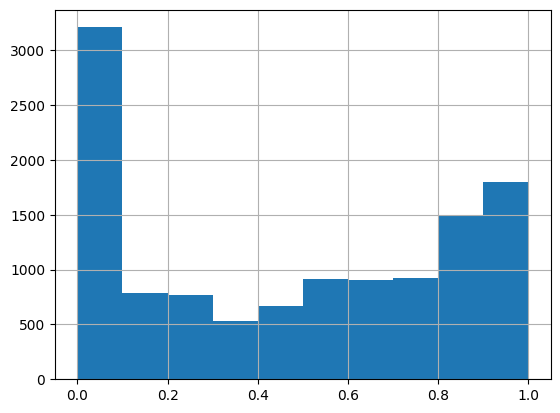

In [67]:
train_analysis_df["gt"].hist()

<Axes: >

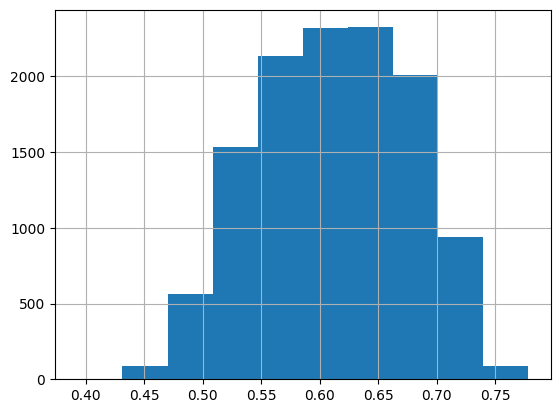

In [68]:
train_analysis_df["preds_sigmoid"].hist()

<Axes: >

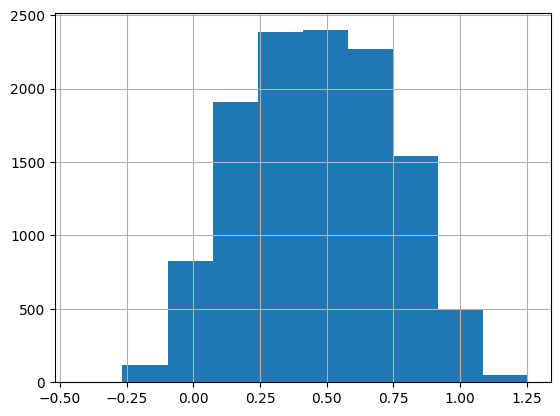

In [69]:
train_analysis_df["preds"].hist()

In [70]:
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

# Check the nature of ground truth values
print("Ground truth value range:")
print(f"Train gt - min: {train_analysis_df['gt'].min():.4f}, max: {train_analysis_df['gt'].max():.4f}")
print(f"Test gt - min: {test_analysis_df['gt'].min():.4f}, max: {test_analysis_df['gt'].max():.4f}")
print(f"Unique train gt values: {train_analysis_df['gt'].nunique()}")

# MSE using RAW predictions (no sigmoid) - better since probe outputs aren't bounded
train_mse_raw = mean_squared_error(train_analysis_df["gt"], train_analysis_df["preds"])
test_mse_raw = mean_squared_error(test_analysis_df["gt"], test_analysis_df["preds"])

print(f"\nMSE (raw predictions):")
print(f"Train MSE: {train_mse_raw:.4f}")
print(f"Test MSE: {test_mse_raw:.4f}")

# MSE using sigmoid predictions for comparison
train_mse_sigmoid = mean_squared_error(train_analysis_df["gt"], train_analysis_df["preds_sigmoid"])
test_mse_sigmoid = mean_squared_error(test_analysis_df["gt"], test_analysis_df["preds_sigmoid"])

print(f"\nMSE (sigmoid predictions):")
print(f"Train MSE: {train_mse_sigmoid:.4f}")
print(f"Test MSE: {test_mse_sigmoid:.4f}")

# If gt values are truly binary (0 or 1), we can do classification metrics
# First convert gt to int if they are 0.0/1.0 floats
if set(train_analysis_df["gt"].unique()).issubset({0, 1, 0.0, 1.0}):
    train_gt_binary = train_analysis_df["gt"].astype(int)
    test_gt_binary = test_analysis_df["gt"].astype(int)
    
    # Binary predictions using threshold on raw predictions (threshold at 0.5 or median)
    threshold = 0.5
    train_preds_binary = (train_analysis_df["preds_sigmoid"] >= threshold).astype(int)
    test_preds_binary = (test_analysis_df["preds_sigmoid"] >= threshold).astype(int)
    
    train_acc = accuracy_score(train_gt_binary, train_preds_binary)
    test_acc = accuracy_score(test_gt_binary, test_preds_binary)
    
    print(f"\nClassification Metrics (threshold={threshold}):")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    print("\n--- Train Classification Report ---")
    print(classification_report(train_gt_binary, train_preds_binary))
    
    print("--- Test Classification Report ---")
    print(classification_report(test_gt_binary, test_preds_binary))
else:
    print("\nGround truth is continuous - classification metrics not applicable")

Ground truth value range:
Train gt - min: 0.0000, max: 1.0000
Test gt - min: 0.0000, max: 1.0000
Unique train gt values: 51

MSE (raw predictions):
Train MSE: 0.0517
Test MSE: 0.0786

MSE (sigmoid predictions):
Train MSE: 0.1177
Test MSE: 0.1528

Ground truth is continuous - classification metrics not applicable


In [71]:
# =============================================================================
# ANALYSIS: Binned Classification for Success Rate Prediction
# =============================================================================
# Goal: Evaluate how well the probe predicts difficulty categories
# 0 = Very Hard (low success rate), 1 = Very Easy (high success rate)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define bins: [0, 0.2) = Very Hard, [0.2, 0.4) = Hard, [0.4, 0.6) = Medium, 
#              [0.6, 0.8) = Easy, [0.8, 1.0] = Very Easy
bin_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.01]  # 1.01 to include 1.0
bin_labels = ['Very Hard\n(0-0.2)', 'Hard\n(0.2-0.4)', 'Medium\n(0.4-0.6)', 
              'Easy\n(0.6-0.8)', 'Very Easy\n(0.8-1.0)']

# Bin the ground truth and predictions
train_gt_binned = pd.cut(train_analysis_df["gt"], bins=bin_edges, labels=bin_labels, include_lowest=True)
test_gt_binned = pd.cut(test_analysis_df["gt"], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Clip raw predictions to [0, 1] before binning (since they can be outside this range)
train_preds_clipped = np.clip(train_analysis_df["preds"], 0, 1)
test_preds_clipped = np.clip(test_analysis_df["preds"], 0, 1)

train_preds_binned = pd.cut(train_preds_clipped, bins=bin_edges, labels=bin_labels, include_lowest=True)
test_preds_binned = pd.cut(test_preds_clipped, bins=bin_edges, labels=bin_labels, include_lowest=True)

print("=" * 60)
print("BINNED CLASSIFICATION ANALYSIS (5 Classes)")
print("=" * 60)

# Distribution of ground truth bins
print("\nGround Truth Distribution:")
print("Train:")
print(train_gt_binned.value_counts().sort_index())
print("\nTest:")
print(test_gt_binned.value_counts().sort_index())

# Accuracy
train_bin_acc = (train_gt_binned == train_preds_binned).mean()
test_bin_acc = (test_gt_binned == test_preds_binned).mean()

print(f"\n5-Class Binned Accuracy:")
print(f"Train: {train_bin_acc:.4f}")
print(f"Test: {test_bin_acc:.4f}")

# Classification report
print("\n--- Train Classification Report (Binned) ---")
print(classification_report(train_gt_binned, train_preds_binned, zero_division=0))

print("--- Test Classification Report (Binned) ---")
print(classification_report(test_gt_binned, test_preds_binned, zero_division=0))

BINNED CLASSIFICATION ANALYSIS (5 Classes)

Ground Truth Distribution:
Train:
gt
Very Hard\n(0-0.2)      4132
Hard\n(0.2-0.4)         1293
Medium\n(0.4-0.6)       1450
Easy\n(0.6-0.8)         2062
Very Easy\n(0.8-1.0)    3062
Name: count, dtype: int64

Test:
gt
Very Hard\n(0-0.2)      234
Hard\n(0.2-0.4)          68
Medium\n(0.4-0.6)        56
Easy\n(0.6-0.8)          54
Very Easy\n(0.8-1.0)     88
Name: count, dtype: int64

5-Class Binned Accuracy:
Train: 0.4282
Test: 0.3780

--- Train Classification Report (Binned) ---
                     precision    recall  f1-score   support

     Easy
(0.6-0.8)       0.29      0.35      0.31      2062
     Hard
(0.2-0.4)       0.20      0.43      0.27      1293
   Medium
(0.4-0.6)       0.21      0.41      0.28      1450
Very Easy
(0.8-1.0)       0.84      0.42      0.56      3062
  Very Hard
(0-0.2)       0.85      0.48      0.61      4132

           accuracy                           0.43     11999
          macro avg       0.48      0.42    

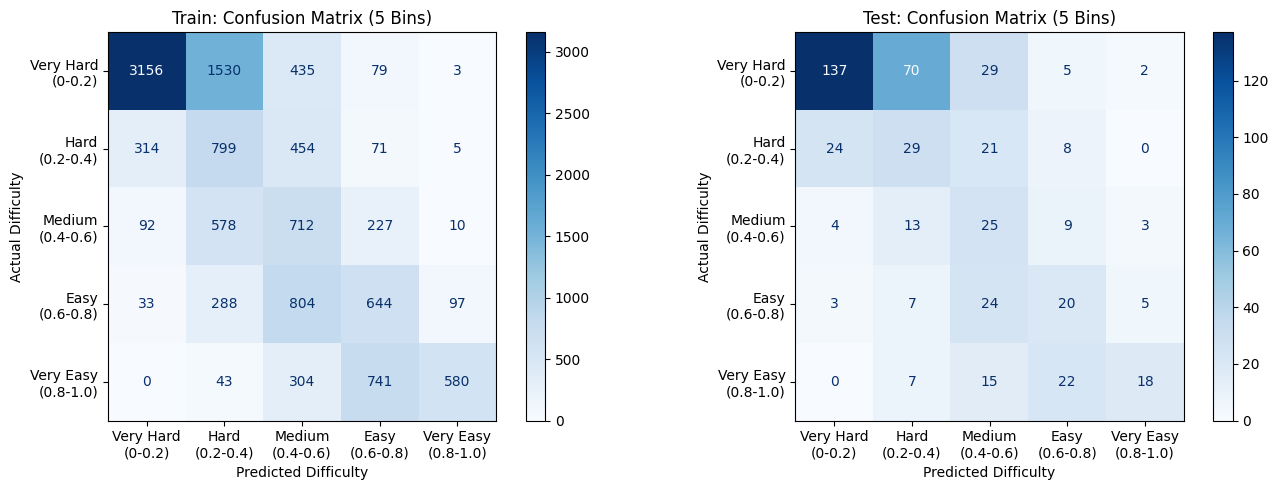

In [43]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train confusion matrix
cm_train = confusion_matrix(train_gt_binned, train_preds_binned, labels=bin_labels)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=bin_labels)
disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Train: Confusion Matrix (5 Bins)')
axes[0].set_xlabel('Predicted Difficulty')
axes[0].set_ylabel('Actual Difficulty')

# Test confusion matrix
cm_test = confusion_matrix(test_gt_binned, test_preds_binned, labels=bin_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=bin_labels)
disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Test: Confusion Matrix (5 Bins)')
axes[1].set_xlabel('Predicted Difficulty')
axes[1].set_ylabel('Actual Difficulty')

plt.tight_layout()
plt.show()

In [73]:
# =============================================================================
# FOCUSED ANALYSIS: Extremes Only (Very Hard vs Very Easy)
# =============================================================================
# This is what you care about most: can the model distinguish 
# really easy (success rate >= 0.8) from really hard (success rate <= 0.2)?

print("=" * 60)
print(f"EXTREME DIFFICULTY ANALYSIS {CHOSEN_MODEL} (Very Hard vs Very Easy)")
print("=" * 60)

# Filter to only extreme cases in ground truth
train_extreme_mask = (train_analysis_df["gt"] <= 0.2) | (train_analysis_df["gt"] >= 0.8)
test_extreme_mask = (test_analysis_df["gt"] <= 0.2) | (test_analysis_df["gt"] >= 0.8)

print(f"\nSamples with extreme difficulty:")
print(f"Train: {train_extreme_mask.sum()} / {len(train_analysis_df)} ({100*train_extreme_mask.mean():.1f}%)")
print(f"Test: {test_extreme_mask.sum()} / {len(test_analysis_df)} ({100*test_extreme_mask.mean():.1f}%)")

# Create binary labels: 0 = Very Hard (<=0.2), 1 = Very Easy (>=0.8)
train_extreme_gt = (train_analysis_df.loc[train_extreme_mask, "gt"] >= 0.8).astype(int)
test_extreme_gt = (test_analysis_df.loc[test_extreme_mask, "gt"] >= 0.8).astype(int)

# Predictions: threshold at 0.5 on raw predictions
train_extreme_preds = (train_analysis_df.loc[train_extreme_mask, "preds"] >= 0.5).astype(int)
test_extreme_preds = (test_analysis_df.loc[test_extreme_mask, "preds"] >= 0.5).astype(int)

if train_extreme_mask.sum() > 0:
    train_extreme_acc = accuracy_score(train_extreme_gt, train_extreme_preds)
    test_extreme_acc = accuracy_score(test_extreme_gt, test_extreme_preds)
    
    print(f"\nBinary Accuracy (Very Hard=0 vs Very Easy=1):")
    print(f"Train: {train_extreme_acc:.4f}")
    print(f"Test: {test_extreme_acc:.4f}")
    
    print("\n--- Train: Extreme Cases Classification Report ---")
    print(classification_report(train_extreme_gt, train_extreme_preds, 
                                target_names=['Very Hard (≤0.2)', 'Very Easy (≥0.8)'], zero_division=0))
    
    print("--- Test: Extreme Cases Classification Report ---")
    print(classification_report(test_extreme_gt, test_extreme_preds,
                                target_names=['Very Hard (≤0.2)', 'Very Easy (≥0.8)'], zero_division=0))

EXTREME DIFFICULTY ANALYSIS Qwen2.5-Math-1.5B-Instruct (Very Hard vs Very Easy)

Samples with extreme difficulty:
Train: 7430 / 11999 (61.9%)
Test: 330 / 500 (66.0%)

Binary Accuracy (Very Hard=0 vs Very Easy=1):
Train: 0.9118
Test: 0.8606

--- Train: Extreme Cases Classification Report ---
                  precision    recall  f1-score   support

Very Hard (≤0.2)       0.93      0.91      0.92      4132
Very Easy (≥0.8)       0.89      0.91      0.90      3298

        accuracy                           0.91      7430
       macro avg       0.91      0.91      0.91      7430
    weighted avg       0.91      0.91      0.91      7430

--- Test: Extreme Cases Classification Report ---
                  precision    recall  f1-score   support

Very Hard (≤0.2)       0.95      0.85      0.90       234
Very Easy (≥0.8)       0.71      0.89      0.79        96

        accuracy                           0.86       330
       macro avg       0.83      0.87      0.84       330
    weighted av

In [ ]:
# ============================================================
# EXTREME DIFFICULTY ANALYSIS (Very Hard vs Very Easy)
# ============================================================

# Samples with extreme difficulty:
# Train: 7050 / 11999 (58.8%)
# Test: 312 / 500 (62.4%)

# Binary Accuracy (Very Hard=0 vs Very Easy=1):
# Train: 0.9474
# Test: 0.9071

# --- Train: Extreme Cases Classification Report ---
#                   precision    recall  f1-score   support

# Very Hard (≤0.2)       0.97      0.96      0.96      5203
# Very Easy (≥0.8)       0.90      0.90      0.90      1847

#         accuracy                           0.95      7050
#        macro avg       0.93      0.93      0.93      7050
#     weighted avg       0.95      0.95      0.95      7050

# --- Test: Extreme Cases Classification Report ---
#                   precision    recall  f1-score   support

# Very Hard (≤0.2)       0.94      0.94      0.94       243
# Very Easy (≥0.8)       0.79      0.80      0.79        69

#         accuracy                           0.91       312
#        macro avg       0.86      0.87      0.87       312
#     weighted avg       0.91      0.91      0.91       312



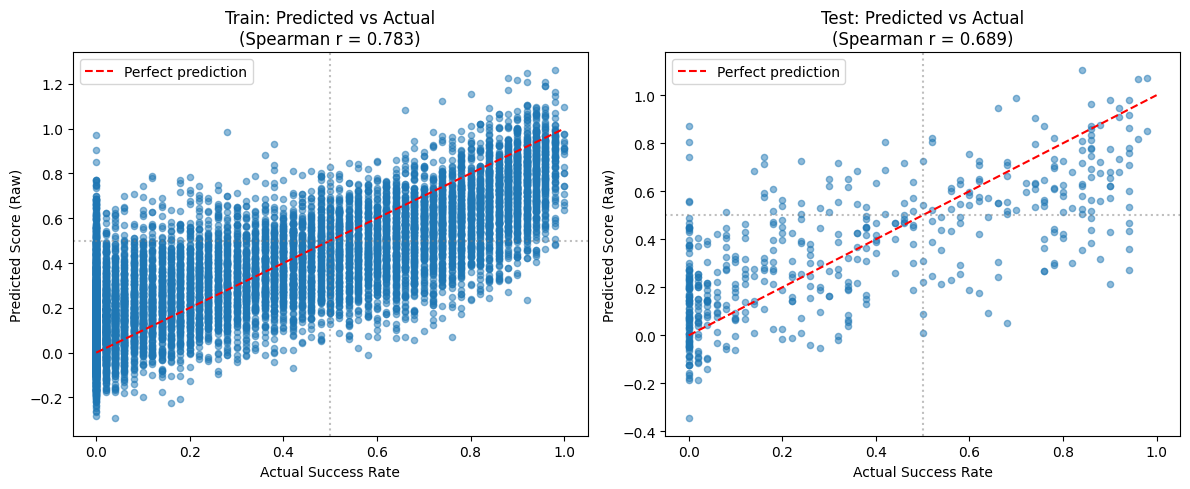


Correlation Summary:
Train Spearman: 0.7833
Test Spearman: 0.6886
Train Pearson: 0.7936
Test Pearson: 0.7028


In [45]:
# =============================================================================
# SCATTER PLOT: Predictions vs Actual
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train scatter
axes[0].scatter(train_analysis_df["gt"], train_analysis_df["preds"], alpha=0.5, s=20)
axes[0].plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
axes[0].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Actual Success Rate')
axes[0].set_ylabel('Predicted Score (Raw)')
axes[0].set_title(f'Train: Predicted vs Actual\n(Spearman r = {spearmanr(train_analysis_df["gt"], train_analysis_df["preds"])[0]:.3f})')
axes[0].legend()

# Test scatter
axes[1].scatter(test_analysis_df["gt"], test_analysis_df["preds"], alpha=0.5, s=20)
axes[1].plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
axes[1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Actual Success Rate')
axes[1].set_ylabel('Predicted Score (Raw)')
axes[1].set_title(f'Test: Predicted vs Actual\n(Spearman r = {spearmanr(test_analysis_df["gt"], test_analysis_df["preds"])[0]:.3f})')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print correlation summary
print("\nCorrelation Summary:")
print(f"Train Spearman: {spearmanr(train_analysis_df['gt'], train_analysis_df['preds'])[0]:.4f}")
print(f"Test Spearman: {spearmanr(test_analysis_df['gt'], test_analysis_df['preds'])[0]:.4f}")
print(f"Train Pearson: {pearsonr(train_analysis_df['gt'], train_analysis_df['preds'])[0]:.4f}")
print(f"Test Pearson: {pearsonr(test_analysis_df['gt'], test_analysis_df['preds'])[0]:.4f}")

In [56]:
len(test_analysis_df[test_analysis_df["preds"] <= 0.0])

50

In [58]:
# =============================================================================
# FOCUSED ANALYSIS: Extremes Only (Very Hard vs Very Easy)
# =============================================================================
# This is what you care about most: can the model distinguish 
# really easy (success rate >= .9) from really hard (success rate <= 0.0)?

print("=" * 60)
print("EXTREME DIFFICULTY ANALYSIS (Very Hard vs Very Easy)")
print("=" * 60)

# Filter to only extreme cases in ground truth
train_extreme_mask = (train_analysis_df["gt"] <= 0.0) | (train_analysis_df["gt"] >= .9)
test_extreme_mask = (test_analysis_df["gt"] <= 0.0) | (test_analysis_df["gt"] >= .9)

print(f"\nSamples with extreme difficulty:")
print(f"Train: {train_extreme_mask.sum()} / {len(train_analysis_df)} ({100*train_extreme_mask.mean():.1f}%)")
print(f"Test: {test_extreme_mask.sum()} / {len(test_analysis_df)} ({100*test_extreme_mask.mean():.1f}%)")

# Create binary labels: 0 = Very Hard (<=0.0), 1 = Very Easy (>=.9)
train_extreme_gt = (train_analysis_df.loc[train_extreme_mask, "gt"] >= .9).astype(int)
test_extreme_gt = (test_analysis_df.loc[test_extreme_mask, "gt"] >= .9).astype(int)

# Predictions: threshold at 0.5 on raw predictions
train_extreme_preds = (train_analysis_df.loc[train_extreme_mask, "preds"] >= 0.5).astype(int)
test_extreme_preds = (test_analysis_df.loc[test_extreme_mask, "preds"] >= 0.5).astype(int)

if train_extreme_mask.sum() > 0:
    train_extreme_acc = accuracy_score(train_extreme_gt, train_extreme_preds)
    test_extreme_acc = accuracy_score(test_extreme_gt, test_extreme_preds)
    
    print(f"\nBinary Accuracy (Very Hard=0 vs Very Easy=1):")
    print(f"Train: {train_extreme_acc:.4f}")
    print(f"Test: {test_extreme_acc:.4f}")
    
    print("\n--- Train: Extreme Cases Classification Report ---")
    print(classification_report(train_extreme_gt, train_extreme_preds, 
                                target_names=['Very Hard (≤0.0)', 'Very Easy (≥.9)'], zero_division=0))
    
    print("--- Test: Extreme Cases Classification Report ---")
    print(classification_report(test_extreme_gt, test_extreme_preds,
                                target_names=['Very Hard (≤0.0)', 'Very Easy (≥.9)'], zero_division=0))

EXTREME DIFFICULTY ANALYSIS (Very Hard vs Very Easy)

Samples with extreme difficulty:
Train: 3264 / 11999 (27.2%)
Test: 134 / 500 (26.8%)

Binary Accuracy (Very Hard=0 vs Very Easy=1):
Train: 0.9614
Test: 0.9179

--- Train: Extreme Cases Classification Report ---
                  precision    recall  f1-score   support

Very Hard (≤0.0)       0.99      0.96      0.97      2425
 Very Easy (≥.9)       0.89      0.96      0.93       839

        accuracy                           0.96      3264
       macro avg       0.94      0.96      0.95      3264
    weighted avg       0.96      0.96      0.96      3264

--- Test: Extreme Cases Classification Report ---
                  precision    recall  f1-score   support

Very Hard (≤0.0)       0.94      0.95      0.95       105
 Very Easy (≥.9)       0.82      0.79      0.81        29

        accuracy                           0.92       134
       macro avg       0.88      0.87      0.88       134
    weighted avg       0.92      0.92     